# ONE Quick Start
This tutorial will get you started searching and loading IBL data using Open Neurophysiology
Environment (ONE).

First we need to install ONE. If you don't already have IBL libraries, the easiest way is to run
 `pip install ONE-api`.

Now we need to import the ONE library and open a connection to the IBL public data server. To do
so, we create an ONE object, and ask it to connect to the IBL public server.

<div class="alert alert-info">
Info.

IBL internal users may use their Alyx credentials to access all IBL data.
[Click here](https://int-brain-lab.github.io/ONE/one_installation.html#connecting-to-specific-database-relevant-for-ibl-users) for details.
</div>

In [10]:
from one.api import ONE
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)

Now we are going to search for an experiment to analyze. First let's find out what we can search by:

In [11]:
print(one.search_terms())

('dataset', 'date_range', 'laboratory', 'number', 'project', 'subject', 'task_protocol')


Let's search for sessions recorded in September 2020, which contain a dataset 'probes.description',
meaning that electrophysiology was recorded. By adding the argument `details=True`, we get two
outputs - the experiment IDs uniquely identifying these sessions, and some information about the
experiments.

In [12]:
eids, info = one.search(date_range=['2020-09-01', '2021-09-30'], dataset='probes.description', details=True)

from pprint import pprint
pprint(eids)
pprint(info)

['4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a', 'c7bd79c9-c47e-4ea5-aea3-74dda991b48e']
[{'date': datetime.date(2020, 9, 21),
  'lab': 'hoferlab',
  'number': 1,
  'project': 'ibl_neuropixel_brainwide_01',
  'subject': 'SWC_043',
  'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2'},
 {'date': datetime.date(2020, 9, 19),
  'lab': 'zadorlab',
  'number': 1,
  'project': 'ibl_neuropixel_brainwide_01',
  'subject': 'CSH_ZAD_029',
  'task_protocol': '_iblrig_tasks_ephysChoiceWorld6.4.2'}]


So there were two experiments matching the criteria in the public database. Now let's load the
probe information for the first experiment. `one.load_dataset` returns a single named dataset

In [13]:
eid = eids[0]  # Select the first experiment
probe_insertions = one.load_dataset(eid, 'probes.description')

print(f'N probes = {len(probe_insertions)}')
pprint(probe_insertions[0])

N probes = 2
{'label': 'probe00',
 'model': '3B2',
 'raw_file_name': 'D:/iblrig_data/Subjects/SWC_043/2020-09-21/001/raw_ephys_data/_spikeglx_ephysData_g0/_spikeglx_ephysData_g0_imec0/_spikeglx_ephysData_g0_t0.imec0.ap.bin',
 'serial': 19108320031}


Now let's see all the datasets associated with the first of these experiments. The command `one.list_datasets`
returns the full path of all datasets, including the collection name and the extension. The
'alf' collection contains the preprocessed data we usually want to work with, and the data for
each probe are in labeled subdirectories:

In [14]:
probe_label = probe_insertions[0]['label']
one.list_datasets(eid, collection=f'alf/{probe_label}')

['alf/probe00/_kilosort_whitening.matrix.npy',
 'alf/probe00/_phy_spikes_subset.channels.npy',
 'alf/probe00/_phy_spikes_subset.spikes.npy',
 'alf/probe00/_phy_spikes_subset.waveforms.npy',
 'alf/probe00/channels.localCoordinates.npy',
 'alf/probe00/channels.rawInd.npy',
 'alf/probe00/clusters.amps.npy',
 'alf/probe00/clusters.channels.npy',
 'alf/probe00/clusters.depths.npy',
 'alf/probe00/clusters.metrics.pqt',
 'alf/probe00/clusters.peakToTrough.npy',
 'alf/probe00/clusters.uuids.csv',
 'alf/probe00/clusters.waveforms.npy',
 'alf/probe00/clusters.waveformsChannels.npy',
 'alf/probe00/spikes.amps.npy',
 'alf/probe00/spikes.clusters.npy',
 'alf/probe00/spikes.depths.npy',
 'alf/probe00/spikes.samples.npy',
 'alf/probe00/spikes.templates.npy',
 'alf/probe00/spikes.times.npy',
 'alf/probe00/templates.amps.npy',
 'alf/probe00/templates.waveforms.npy',
 'alf/probe00/templates.waveformsChannels.npy']

Here we'll load the electrophysiology information. There are two ways to do this.
`one.load_dataset` or `one.load_object`, which returns all the datasets with the same name part,
as an object. Let's use the second method to load the spike times, depths, and amplitudes for
probe00:

In [15]:
spikes = one.load_object(eids[0], 'spikes',
                         collection='alf/probe00', attribute=['times', 'depths', 'amps'])
spikes

{'depths': array([2370.48211274, 3540.09356959, 3181.26894624, ...,  696.96694218,
         926.12358345, 1332.7635685 ]),
 'amps': array([2.90908158e-04, 6.97262477e-04, 2.76331535e-04, ...,
        1.11343402e-04, 8.49250479e-05, 6.29040371e-05]),
 'times': array([4.28914123e-03, 5.48913109e-03, 5.72246245e-03, ...,
        4.29596044e+03, 4.29596067e+03, 4.29596094e+03])}

We can import a module from brainbox that plots the raster across time
<div class="alert alert-info">
Note.

Requires [ibllib](https://github.com/int-brain-lab/ibllib#readme) to be installed.
</div>

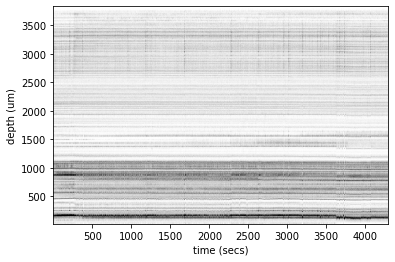

In [16]:
from brainbox.plot import driftmap
driftmap(spikes.times, spikes.depths, t_bin=0.1, d_bin=5);

And that's the end of the quick start tutorial! For more information on any of these commands you
can use the standard help function:

In [17]:
help(one.list_datasets)

Help on method list_datasets in module one.api:

list_datasets(eid=None, collection=None, filename=None, revision=None, details=False, query_type=None) -> Union[numpy.ndarray, pandas.core.frame.DataFrame] method of one.api.OneAlyx instance
    Given an eid, return the datasets for those sessions.  If no eid is provided,
    a list of all datasets is returned.  When details is false, a sorted array of unique
    datasets is returned (their relative paths).
    
    Parameters
    ----------
    eid : str, UUID, pathlib.Path, dict
        Experiment session identifier; may be a UUID, URL, experiment reference string
        details dict or Path.
    collection : str
        The collection to which the object belongs, e.g. 'alf/probe01'.
        This is the relative path of the file from the session root.
        Supports asterisks as wildcards.
    filename : str
        Filters datasets and returns only the ones matching the filename
        Supports asterisks as wildcards
    revision 

For detailed tutorials, guides and examples, [click here for the full ONE API documentation
Website](https://int-brain-lab.github.io/ONE/).